In [2]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

#import pickle5 as pickle
from tqdm import tqdm  # Instead of tqdm.notebook

In [3]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array")
#env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="human")


In [4]:
# We create our environment with gym.make("<name_of_the_environment>")- `is_slippery=False`: The agent always moves in the intended direction due to the non-slippery nature of the frozen lake (deterministic).
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(64)
Sample observation 34


In [5]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 1


In [6]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  64  possible states
There are  4  possible actions


In [7]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [8]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

In [9]:
def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state][:])

    return action

In [10]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_num = random.uniform(0,1)
    # if random_num > greater than epsilon --> exploitation
    if random_num > epsilon:
        # Take the action with the highest value given a state
        # np.argmax can be useful here
        action = greedy_policy(Qtable, state)
    # else --> exploration
    else:
        action = env.action_space.sample()

    return action

In [11]:
# Training parameters
n_training_episodes = 100000  # Total training episodes
learning_rate = 0.1          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 300               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.001            # Exponential decay rate for exploration prob

In [14]:
def debug_train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    # Lists to keep track of rewards
    episode_rewards = []
    successful_episodes = []

    for episode in range(min(100, n_training_episodes)):  # Let's just look at first 100 episodes for debugging
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        state, info = env.reset()

        print(f"\nEpisode {episode}")
        print(f"Starting state: {state}")

        for step in range(max_steps):
            # Print current state and Q-values
            print(f"\nStep {step}")
            print(f"Current state: {state}")
            print(f"Q-values for current state: {Qtable[state]}")

            # Choose and print action
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            print(f"Chosen action: {action}")

            # Take action and print results
            old_q = Qtable[state][action]
            new_state, reward, terminated, truncated, info = env.step(action)

            print(f"New state: {new_state}")
            print(f"Reward: {reward}")
            print(f"Terminated: {terminated}")

            # Update Q-value
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                    reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )

            print(f"Old Q-value: {old_q}")
            print(f"New Q-value: {Qtable[state][action]}")

            if reward > 0:
                print("GOAL REACHED!")
                successful_episodes.append(episode)

            if terminated or truncated:
                break

            state = new_state

        if episode % 10 == 0:
            print(f"\nSuccessful episodes so far: {successful_episodes}")

    return Qtable, successful_episodes

# Test environment layout
print("Environment Layout:")
env.reset()
desc = env.render()
print(desc)

# Run debug training
print("\nStarting debug training...")
Qtable_frozenlake, successful_episodes = debug_train(
    n_training_episodes=100,
    min_epsilon=max_epsilon,
    max_epsilon=max_epsilon,
    decay_rate=decay_rate,
    env=env,
    max_steps=max_steps,
    Qtable=initialize_q_table(state_space, action_space)
)

print("\nDebug Summary:")
print(f"Total successful episodes: {len(successful_episodes)}")
print(f"Successful episodes: {successful_episodes}")

Environment Layout:
[[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]

Starting debug training...

Episode 0
Starting state: 0

Step 0
Current state: 0
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 2
New state: 1
Reward: 0.0
Terminated: False
Old Q-value: 0.0
New Q-value: 0.0

Step 1
Current state: 1
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 2
New state: 2
Reward: 0.0
Terminated: False
Old Q

In [15]:
# First reset the parameters to make debugging easier
n_training_episodes = 100  # Reduced for debugging
learning_rate = 0.1
max_steps = 200
gamma = 0.95

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.001

# Initialize a fresh Q-table
Qtable_frozenlake = initialize_q_table(state_space, action_space)

# Now run the debug training instead of the regular training
print("\nStarting debug training...")
Qtable_frozenlake, successful_episodes = debug_train(
    n_training_episodes=n_training_episodes,
    min_epsilon=max_epsilon,
    max_epsilon=max_epsilon,
    decay_rate=decay_rate,
    env=env,
    max_steps=max_steps,
    Qtable=Qtable_frozenlake
)

print("\nDebug Summary:")
print(f"Total successful episodes: {len(successful_episodes)}")
print(f"Successful episodes: {successful_episodes}")


Starting debug training...

Episode 0
Starting state: 0

Step 0
Current state: 0
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 1
New state: 8
Reward: 0.0
Terminated: False
Old Q-value: 0.0
New Q-value: 0.0

Step 1
Current state: 8
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 2
New state: 9
Reward: 0.0
Terminated: False
Old Q-value: 0.0
New Q-value: 0.0

Step 2
Current state: 9
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 1
New state: 17
Reward: 0.0
Terminated: False
Old Q-value: 0.0
New Q-value: 0.0

Step 3
Current state: 17
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 2
New state: 18
Reward: 0.0
Terminated: False
Old Q-value: 0.0
New Q-value: 0.0

Step 4
Current state: 18
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 0
New state: 17
Reward: 0.0
Terminated: False
Old Q-value: 0.0
New Q-value: 0.0

Step 5
Current state: 17
Q-values for current state: [0. 0. 0. 0.]
Chosen action: 1
New state: 25
Reward: 0.0
Terminated: False
Old 

In [16]:
# Reset and render the environment to see the layout
env.reset()
print("\nEnvironment Layout (8x8 grid):")
print(env.render())

# Print what each character means
print("\nSymbol meanings:")
print("S: Starting position (state 0)")
print("F: Frozen surface (safe)")
print("H: Hole (game over)")
print("G: Goal (state 63)")


Environment Layout (8x8 grid):
[[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]

Symbol meanings:
S: Starting position (state 0)
F: Frozen surface (safe)
H: Hole (game over)
G: Goal (state 63)


In [17]:
def improved_debug_train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    # Lists to keep track of rewards
    episode_rewards = []
    successful_episodes = []

    for episode in range(min(100, n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        state, info = env.reset()
        total_reward = 0

        print(f"\nEpisode {episode}")
        print(f"Starting state: {state}")

        for step in range(max_steps):
            # Current state info
            print(f"\nStep {step}")
            print(f"Current state: {state}")
            print(f"Q-values for current state: {Qtable[state]}")

            # Choose action with epsilon-greedy
            random_num = random.uniform(0, 1)
            if random_num > epsilon:
                action = np.argmax(Qtable[state])
                print(f"Exploiting - Chosen action: {action}")
            else:
                action = env.action_space.sample()
                print(f"Exploring - Chosen action: {action}")

            # Take action
            old_q = Qtable[state][action]
            new_state, reward, terminated, truncated, info = env.step(action)

            # Add small negative reward for each step to encourage shorter paths
            reward = reward - 0.01

            # Calculate new Q-value
            if terminated and reward <= 0:  # If terminated in a hole
                new_q = Qtable[state][action] + learning_rate * (reward - Qtable[state][action])
            else:  # Normal case or reached goal
                new_q = Qtable[state][action] + learning_rate * (
                        reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
                )

            # Update Q-value
            Qtable[state][action] = new_q

            print(f"New state: {new_state}")
            print(f"Reward: {reward}")
            print(f"Terminated: {terminated}")
            print(f"Old Q-value: {old_q}")
            print(f"New Q-value: {new_q}")

            total_reward += reward

            if reward > 0:
                print("GOAL REACHED!")
                successful_episodes.append(episode)

            if terminated or truncated:
                break

            state = new_state

        episode_rewards.append(total_reward)
        if episode % 10 == 0:
            print(f"\nEpisode {episode} summary:")
            print(f"Total reward: {total_reward}")
            print(f"Successful episodes so far: {successful_episodes}")
            print(f"Average reward over last {min(episode+1, 10)} episodes: {np.mean(episode_rewards[-10:]):.3f}")

    return Qtable, successful_episodes, episode_rewards

# Updated parameters
learning_rate = 0.1
gamma = 0.95
max_steps = 200
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.001

# Initialize fresh Q-table
Qtable_frozenlake = initialize_q_table(state_space, action_space)

# Run improved debug training
print("\nStarting improved debug training...")
Qtable_frozenlake, successful_episodes, episode_rewards = improved_debug_train(
    n_training_episodes=100,
    min_epsilon=max_epsilon,
    max_epsilon=max_epsilon,
    decay_rate=decay_rate,
    env=env,
    max_steps=max_steps,
    Qtable=Qtable_frozenlake
)


Starting improved debug training...

Episode 0
Starting state: 0

Step 0
Current state: 0
Q-values for current state: [0. 0. 0. 0.]
Exploring - Chosen action: 1
New state: 8
Reward: -0.01
Terminated: False
Old Q-value: 0.0
New Q-value: -0.001

Step 1
Current state: 8
Q-values for current state: [0. 0. 0. 0.]
Exploring - Chosen action: 0
New state: 8
Reward: -0.01
Terminated: False
Old Q-value: 0.0
New Q-value: -0.001

Step 2
Current state: 8
Q-values for current state: [-0.001  0.     0.     0.   ]
Exploring - Chosen action: 3
New state: 0
Reward: -0.01
Terminated: False
Old Q-value: 0.0
New Q-value: -0.001

Step 3
Current state: 0
Q-values for current state: [ 0.    -0.001  0.     0.   ]
Exploring - Chosen action: 2
New state: 1
Reward: -0.01
Terminated: False
Old Q-value: 0.0
New Q-value: -0.001

Step 4
Current state: 1
Q-values for current state: [0. 0. 0. 0.]
Exploring - Chosen action: 3
New state: 1
Reward: -0.01
Terminated: False
Old Q-value: 0.0
New Q-value: -0.001

Step 5
Curr


Starting improved training...

Episode 0
Average reward: -5.180
Success rate: 0.00%

Current Policy:
[['←' '↓' '←' '←' '←' '←' '←' '←']
 ['↓' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']]

Least visited states:
State 3: 0 visits
State 4: 0 visits
State 5: 0 visits
State 6: 0 visits
State 7: 0 visits

Episode 100
Average reward: -5.182
Success rate: 0.00%

Current Policy:
[['↓' '→' '→' '→' '↓' '→' '←' '↓']
 ['↓' '→' '→' '→' '↓' '↓' '↓' '↓']
 ['↓' '→' '↓' '←' '↑' '→' '↓' '→']
 ['↓' '→' '↓' '←' '↓' '←' '→' '→']
 ['↓' '←' '↑' '←' '↓' '→' '↓' '→']
 ['↓' '←' '←' '←' '↓' '↓' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '↓']
 ['↑' '→' '↓' '←' '←' '←' '←' '←']]

Least visited states:
State 19: 0 visits
State 29: 0 visits
State 35: 0 visits
State 41: 0 visits
State 42: 0 visits

GOAL REACHED in episode 123!
Pa

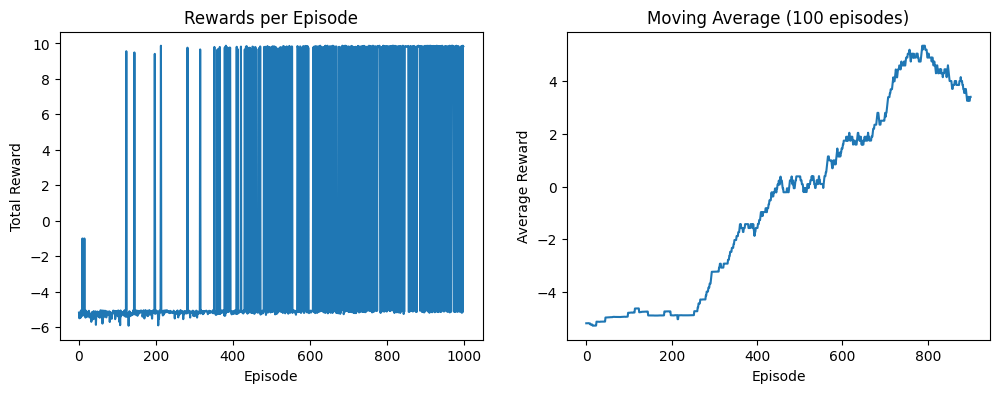

In [20]:
import matplotlib.pyplot as plt

def print_policy(Qtable, shape=(8, 8)):
    """Prints the policy based on the Q-table"""
    policy = np.array([np.argmax(Qtable[i]) for i in range(len(Qtable))])
    arrows = ['←', '↓', '→', '↑']
    policy_arrows = np.array([arrows[a] for a in policy]).reshape(shape)
    print("\nCurrent Policy:")
    print(policy_arrows)

def improved_debug_train_v2(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    episode_rewards = []
    successful_episodes = []

    # Dictionary to track state visitation frequency
    state_visits = {i: 0 for i in range(64)}

    for episode in range(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

        state, info = env.reset()
        total_reward = 0
        episode_steps = []

        for step in range(max_steps):
            state_visits[state] += 1

            # Epsilon-greedy action selection
            random_num = random.uniform(0, 1)
            if random_num > epsilon:
                action = np.argmax(Qtable[state])
            else:
                action = env.action_space.sample()

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)

            # Modified reward structure
            if reward == 1:  # Reached goal
                reward = 10  # Increase reward for reaching goal
            elif terminated:  # Fell in hole
                reward = -5  # Larger penalty for falling in hole
            else:
                reward = -0.01  # Small step penalty

            # Q-value update
            old_q = Qtable[state][action]
            next_max = np.max(Qtable[new_state]) if not terminated else 0
            new_q = Qtable[state][action] + learning_rate * (
                    reward + gamma * next_max - Qtable[state][action]
            )
            Qtable[state][action] = new_q

            episode_steps.append((state, action, reward, new_state))
            total_reward += reward

            if reward == 10:  # Reached goal
                successful_episodes.append(episode)
                print(f"\nGOAL REACHED in episode {episode}!")
                print(f"Path taken: {[(s[0], s[1]) for s in episode_steps]}")
                print_policy(Qtable)
                break

            if terminated or truncated:
                break

            state = new_state

        episode_rewards.append(total_reward)

        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"\nEpisode {episode}")
            print(f"Average reward: {np.mean(episode_rewards[-100:]):.3f}")
            print(f"Success rate: {len([x for x in successful_episodes if x > episode-100])/100:.2%}")
            print_policy(Qtable)

            # Print least visited states
            least_visited = sorted(state_visits.items(), key=lambda x: x[1])[:5]
            print("\nLeast visited states:")
            for state, visits in least_visited:
                print(f"State {state}: {visits} visits")

    return Qtable, successful_episodes, episode_rewards, state_visits

# Reset parameters with modifications
learning_rate = 0.1
gamma = 0.99  # Increased from 0.95 to give more weight to future rewards
max_steps = 200
max_epsilon = 1.0
min_epsilon = 0.1  # Increased from 0.01 to maintain some exploration
decay_rate = 0.002  # Increased for faster decay

# Initialize fresh Q-table
Qtable_frozenlake = initialize_q_table(state_space, action_space)

# Run improved training
print("\nStarting improved training...")
Qtable_frozenlake, successful_episodes, episode_rewards, state_visits = improved_debug_train_v2(
    n_training_episodes=1000,  # Increased episodes
    min_epsilon=min_epsilon,
    max_epsilon=max_epsilon,
    decay_rate=decay_rate,
    env=env,
    max_steps=max_steps,
    Qtable=Qtable_frozenlake
)

# Final policy visualization
print("\nFinal Policy:")
print_policy(Qtable_frozenlake)

# Plot training results
print("\nPlotting results...")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
window_size = 100
moving_avg = [np.mean(episode_rewards[i:i+window_size])
              for i in range(0, len(episode_rewards)-window_size+1)]
plt.plot(moving_avg)
plt.title(f'Moving Average ({window_size} episodes)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.show()

In [12]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    # Lists to keep track of rewards
    episode_rewards = []
    episode_steps = []

    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

        # Reset the environment
        state, info = env.reset()
        step = 0
        total_reward = 0
        terminated = False
        truncated = False

        # Keep track of Q-value changes for debugging
        max_q_change = 0

        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Store old Q-value for debugging
            old_q = Qtable[state][action]

            # Take action At and observe Rt+1 and St+1
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                    reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )

            # Track maximum Q-value change in this step
            q_change = abs(Qtable[state][action] - old_q)
            max_q_change = max(max_q_change, q_change)

            total_reward += reward

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

            # Our next state is the new state
            state = new_state

        # Store episode statistics
        episode_rewards.append(total_reward)
        episode_steps.append(step)

        # Print detailed information every 1000 episodes
        if episode % 1000 == 0:
            print(f"\nEpisode {episode}")
            print(f"Epsilon: {epsilon:.4f}")
            print(f"Steps: {step}")
            print(f"Total reward: {total_reward}")
            print(f"Max Q-value change: {max_q_change:.4f}")
            print(f"Average reward over last 1000 episodes: {np.mean(episode_rewards[-1000:]):.4f}")

            # Print some Q-values for key states
            print("\nSample Q-values for some states:")
            sample_states = [0, 8, 16, 24, 32, 40, 48, 56]  # Edge states
            for s in sample_states:
                print(f"State {s}: {Qtable[s]}")

    return Qtable, episode_rewards, episode_steps


Starting improved training...

Episode 0
Average reward: -5.150
Success rate: 0.00%

Current Policy:
[['→' '←' '←' '←' '←' '←' '←' '←']
 ['←' '↓' '←' '←' '←' '←' '←' '←']
 ['↓' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '↓' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']
 ['←' '←' '←' '←' '←' '←' '←' '←']]

Least visited states:
State 1: 0 visits
State 2: 0 visits
State 3: 0 visits
State 4: 0 visits
State 5: 0 visits

Episode 100
Average reward: -5.248
Success rate: 0.00%

Current Policy:
[['→' '→' '→' '↓' '↓' '→' '→' '↓']
 ['↓' '→' '→' '→' '↓' '←' '→' '←']
 ['→' '→' '↑' '←' '→' '→' '↑' '↑']
 ['↓' '→' '↓' '→' '←' '←' '↑' '↑']
 ['→' '→' '←' '←' '→' '←' '←' '→']
 ['↓' '←' '←' '←' '→' '←' '←' '←']
 ['↓' '←' '←' '←' '←' '←' '←' '←']
 ['↓' '←' '←' '←' '←' '←' '←' '←']]

Least visited states:
State 19: 0 visits
State 29: 0 visits
State 35: 0 visits
State 37: 0 visits
State 41: 0 visits

Episode 200
Average reward: -5.

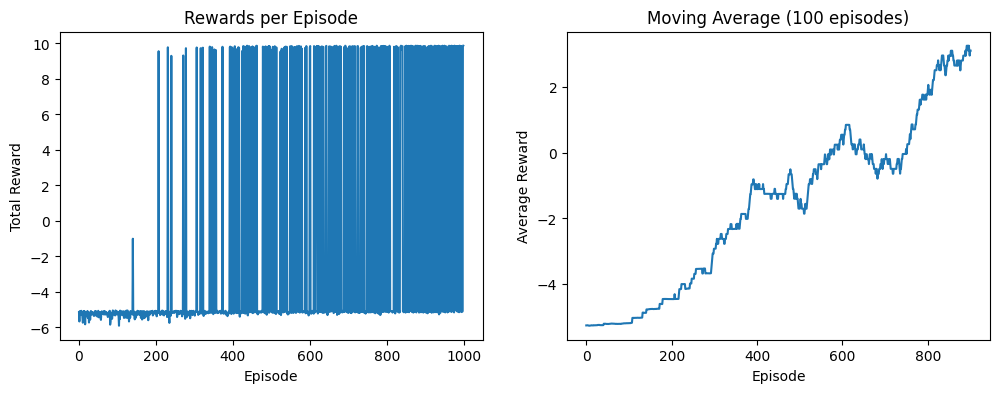

In [23]:
#Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)
# Reset parameters with modifications
learning_rate = 0.1
gamma = 0.99  # Increased from 0.95 to give more weight to future rewards
max_steps = 200
max_epsilon = 1.0
min_epsilon = 0.1  # Increased from 0.01 to maintain some exploration
decay_rate = 0.002  # Increased for faster decay

# Initialize fresh Q-table
Qtable_frozenlake = initialize_q_table(state_space, action_space)

# Run improved training
print("\nStarting improved training...")
Qtable_frozenlake, successful_episodes, episode_rewards, state_visits = improved_debug_train_v2(
    n_training_episodes=1000,  # Increased episodes
    min_epsilon=min_epsilon,
    max_epsilon=max_epsilon,
    decay_rate=decay_rate,
    env=env,
    max_steps=max_steps,
    Qtable=Qtable_frozenlake
)

# Final policy visualization
print("\nFinal Policy:")
print_policy(Qtable_frozenlake)

# Plot training results
print("\nPlotting results...")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
window_size = 100
moving_avg = [np.mean(episode_rewards[i:i+window_size])
              for i in range(0, len(episode_rewards)-window_size+1)]
plt.plot(moving_avg)
plt.title(f'Moving Average ({window_size} episodes)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.show()
#Qtable_frozenlake = improved_debug_train_v2(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

In [22]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param max_steps: Maximum number of steps per episode
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [24]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

100%|██████████| 100/100 [00:00<00:00, 9137.32it/s]

Mean_reward=1.00 +/- 0.00


In [25]:
import numpy as np
import gymnasium as gym
from IPython.display import clear_output
import time

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(0.5)  # Half second between frames

def run_episode(env, Qtable, render=True):
    frames = []
    state, info = env.reset()
    terminated = False
    truncated = False

    while not terminated and not truncated:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state][:])
        new_state, reward, terminated, truncated, info = env.step(action)

        if render:
            frame = env.render()
            frames.append({
                'frame': frame,
                'state': state,
                'action': action,
                'reward': reward
            })

        state = new_state

    return frames

# Create environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")

# Use your trained Q-table here
frames = run_episode(env, Qtable_frozenlake)
print_frames(frames)

# Don't forget to close the environment
env.close()